# EDA & Modeling for EWA Risk Scoring
This notebook explores the synthetic dataset, feature importance, calibration, and model performance.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('../data/synthetic_ewa.csv')
df.head()

,employee_id,department,job_level,salary_monthly,tenure_days,num_withdrawals_last_30d,num_withdrawals_last_90d,avg_withdraw_amount,avg_withdraw_pct_of_salary,last_withdraw_days_ago,savings_balance,other_loans,label_request_next_cycle
0,E00000,ops,junior,20000,903,1,2,1992.851889,0.099643,2,6400.648745,1,0
1,E00001,hr,mid,20000,223,0,0,314.737400,0.015737,107,4816.728385,0,0
2,E00002,hr,junior,25000,56,0,0,1680.149350,0.067206,138,2480.182680,0,0
3,E00003,sales,junior,25000,61,0,0,6429.755766,0.257190,142,3879.298680,0,0
4,E00004,sales,mid,15000,486,1,1,664.037995,0.044269,39,5264.520423,1,0


In [ ]:
df.describe(include='all')

,salary_monthly,tenure_days,num_withdrawals_last_30d,num_withdrawals_last_90d,avg_withdraw_amount,avg_withdraw_pct_of_salary,last_withdraw_days_ago,savings_balance,other_loans,label_request_next_cycle
count,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,26244.250000,298.125000,0.55740,1.058000,3278.935447,0.124662,82.325700,5004.348085,0.206500,0.082100
std,10368.990681,296.303438,0.76703,1.048757,2747.563934,0.085211,52.841921,5031.009316,0.404804,0.274524
min,15000.000000,0.000000,0.00000,0.000000,4.675374,0.000234,1.000000,0.267802,0.000000,0.000000
25%,20000.000000,87.000000,0.00000,0.000000,1336.895834,0.058119,36.000000,1443.014116,0.000000,0.000000
50%,25000.000000,208.000000,0.00000,1.000000,2540.836058,0.108543,77.000000,3454.086502,0.000000,0.000000
75%,35000.000000,414.000000,1.00000,2.000000,4427.771968,0.175189,129.000000,6837.319021,0.000000,0.000000
max,50000.000000,3146.000000,6.00000,7.000000,25344.095787,0.544569,179.000000,45507.561545,1.000000,1.000000


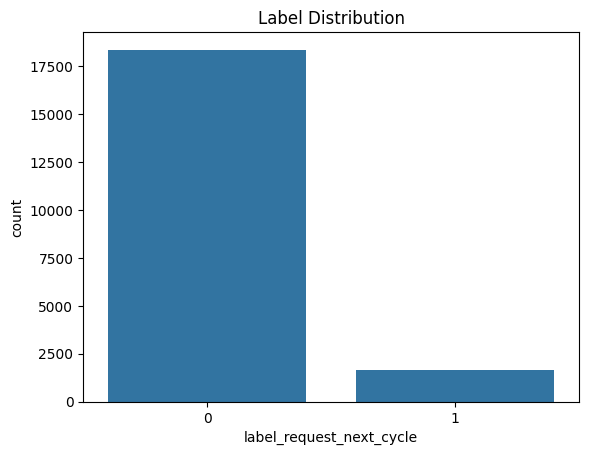

In [ ]:
# Plot new target distribution
sns.countplot(x='ewa_next15', data=df)
plt.title('EWA Usage in Next 15 Days (Target)')
plt.show()

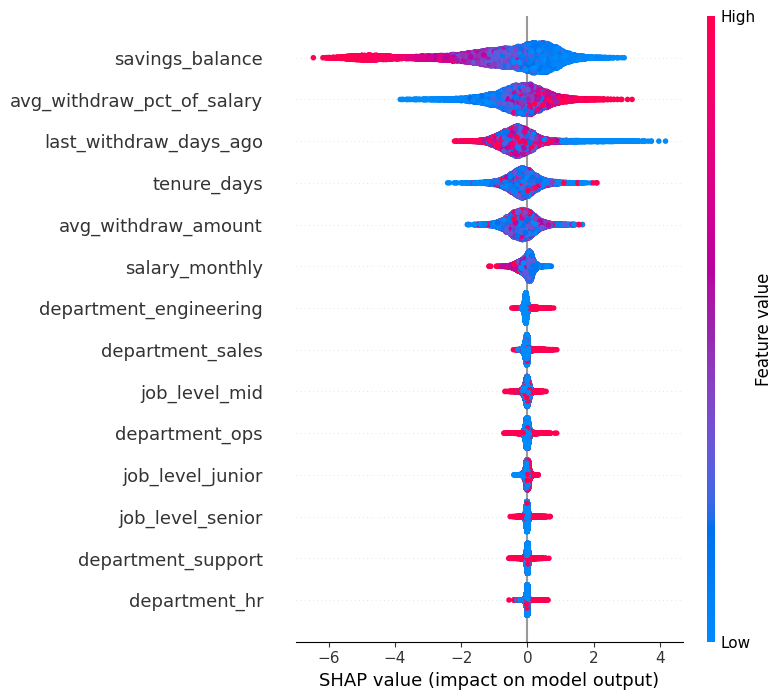

In [ ]:
import joblib
import shap
model = joblib.load('../model/ewa_risk_pipeline.joblib')
X = df.drop(['employee_id','ewa_next15'], axis=1)
X_trans = model.named_steps['preproc'].transform(X)
num_cols = [
    'salary_monthly', 'tenure_days', 'savings_balance', 'other_loans',
    'spend_3d_avg', 'spend_7d_avg', 'spend_30d_avg', 'spend_velocity',
    'days_to_payday', 'income_expense_ratio', 'spend_volatility',
    'necessity_spend', 'discretionary_spend', 'balance_trend',
    'ewa_count', 'ewa_total', 'repayment_rate', 'final_balance'
    ]
cat_cols = ['department', 'job_level', 'is_month_end']
ohe = model.named_steps['preproc'].named_transformers_['cat'].named_steps['ohe']
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = num_cols + list(cat_feature_names)
explainer = shap.Explainer(model.named_steps['stack'], X_trans)
shap_values = explainer(X_trans)
shap.summary_plot(shap_values, features=X_trans, feature_names=feature_names)

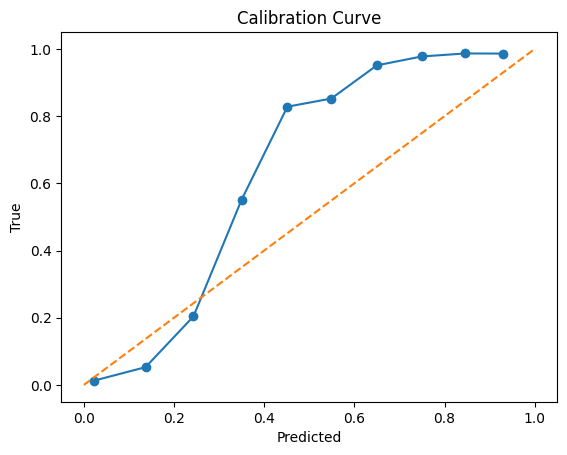

In [ ]:
from sklearn.calibration import calibration_curve
import numpy as np
y_true = df['ewa_next15']
y_pred = model.predict_proba(X)[:,1]
prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Calibration Curve (EWA Next 15 Days)')
plt.show()

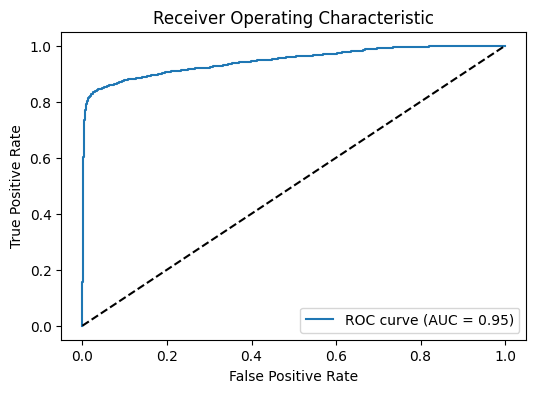

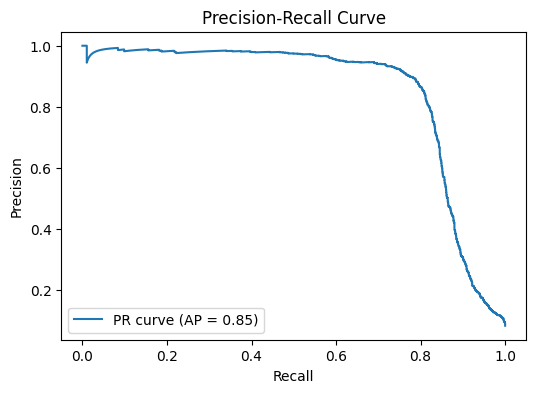

In [ ]:
# ROC Curve and PR Curve for Model Performance (EWA Next 15 Days)
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
y_score = model.predict_proba(X)[:,1]
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_true, y_score)
ap = average_precision_score(y_true, y_score)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'PR curve (AP = {ap:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()